# Frequency-based Loss Analysis: DistilBERT × SimCLR / LIMU-BERT

1개 HuggingFace 모델(DistilBERT) × 2개 학습방식(SimCLR, LIMU-BERT) × 2개 데이터셋(PAMAP2, HHAR) × 2개 초기화(pretrain, randinit) = 총 8개 학습 결과를 주파수 도메인에서 분석합니다.

**x축**: 주파수 bin (FFT frequency index)  
**y축**: 해당 주파수에서의 평균 loss 값

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.max_open_warning'] = 50
from tqdm import tqdm

sys.path.insert(0, '.')
from simCLR import SimCLR, augment_pipeline
from limu_bert import LIMUBert
from hf_backbones import load_model as load_hf_model, model_id_to_name

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

CHECKPOINT_DIR = 'checkpoints'

# 모델/데이터셋/초기화 설정
MODEL_IDS = [
    'distilbert/distilbert-base-uncased',
]
MODEL_SHORT_NAMES = {
    'distilbert/distilbert-base-uncased': 'DistilBERT',
}
DATASETS = ['pamap2', 'hhar']
INIT_MODES = ['pretrain', 'randinit']
METHODS = ['simclr', 'limu_bert']

/mnt/sdb/jl/DNN-Learning-Method-Baseline-Implementation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## 1. 유틸리티 함수: 데이터 로드, 모델 로드, per-sample loss 계산, 주파수별 loss 집계

In [ ]:
def load_test_data(dataset_name, n_samples=1000):
    """저장된 테스트 데이터 로드 및 샘플링"""
    data = np.load(os.path.join(CHECKPOINT_DIR, f'{dataset_name}_test_data.npz'))
    X_test, y_test = data['X_test'], data['y_test']
    rng = np.random.RandomState(42)
    if len(X_test) > n_samples:
        idx = rng.choice(len(X_test), n_samples, replace=False)
        X_test = X_test[idx]
        y_test = y_test[idx]
    print(f'[{dataset_name.upper()}] Test data: {X_test.shape}')
    return X_test, y_test


def compute_avg_frequency_spectrum(X):
    """
    각 샘플의 주파수 스펙트럼(magnitude)을 구하고, 전체 샘플 평균 반환.
    X: (N, seq_len, channels) → freq_spectrum: (N, n_freqs) 채널 평균
    """
    N, T, C = X.shape
    n_freqs = T // 2 + 1
    spectra = np.zeros((N, n_freqs))
    for i in range(N):
        sample_spectrum = np.zeros(n_freqs)
        for ch in range(C):
            fft_vals = np.fft.rfft(X[i, :, ch])
            sample_spectrum += np.abs(fft_vals)
        spectra[i] = sample_spectrum / C
    return spectra  # (N, n_freqs)


def load_model(model_id, method, init_mode, dataset_name):
    """학습된 모델 로드"""
    mname = model_id_to_name(model_id)
    init_tag = init_mode
    ckpt_path = os.path.join(CHECKPOINT_DIR, f'{method}_{mname}_{init_tag}_{dataset_name}_best.pt')
    
    if not os.path.exists(ckpt_path):
        print(f'  [SKIP] {ckpt_path} not found')
        return None
    
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    input_dim = ckpt['input_dim']
    d_model = ckpt['d_model']
    random_init = ckpt.get('random_init', init_mode == 'randinit')
    
    encoder, d_model = load_hf_model(model_id, random_init=random_init)
    
    if method == 'simclr':
        projection_dim = ckpt.get('projection_dim', 64)
        model = SimCLR(encoder, input_dim=input_dim, d_model=d_model, projection_dim=projection_dim)
    else:
        model = LIMUBert(encoder, input_dim=input_dim, d_model=d_model)
    
    model.load_state_dict(ckpt['model_state_dict'])
    model = model.to(device)
    model.eval()
    print(f'  Loaded: {method} | {model_id} | {init_mode} | {dataset_name} (epoch {ckpt["epoch"]}, loss {ckpt["loss"]:.4f})')
    return model


def compute_per_sample_loss_simclr(model, X_test, batch_size=64, temperature=0.5):
    """SimCLR per-sample loss (nt_xent_loss와 동일한 수치 안정적 방식)"""
    model.eval()
    all_losses = []
    X_tensor = torch.FloatTensor(X_test).to(device)
    
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            bs = batch.size(0)
            
            x_view1 = batch + torch.randn_like(batch) * 0.01
            x_view2 = batch + torch.randn_like(batch) * 0.01
            
            z_i = model(x_view1)
            z_j = model(x_view2)
            
            # nt_xent_loss와 동일: 먼저 normalize
            z_i = F.normalize(z_i, dim=1)
            z_j = F.normalize(z_j, dim=1)
            
            z = torch.cat([z_i, z_j], dim=0)
            
            # 수치 안정적 logsumexp 방식
            sim_matrix = torch.mm(z, z.t()) / temperature
            mask_self = torch.eye(2 * bs, device=device).bool()
            sim_matrix.masked_fill_(mask_self, -1e9)
            
            pos_sim = torch.sum(z_i * z_j, dim=1) / temperature
            pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
            
            per_sample_loss = -pos_sim + torch.logsumexp(sim_matrix, dim=1)
            
            # 각 샘플의 두 view 평균
            sample_losses = (per_sample_loss[:bs] + per_sample_loss[bs:]) / 2
            all_losses.append(sample_losses.cpu().numpy())
    
    return np.concatenate(all_losses)


def compute_per_sample_loss_limu_bert(model, X_test, batch_size=64):
    """LIMU-BERT per-sample loss"""
    model.eval()
    all_losses = []
    X_tensor = torch.FloatTensor(X_test).to(device)
    
    torch.manual_seed(42)
    
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            bs = batch.size(0)
            
            mask = torch.rand(batch.shape[:2], device=device) < 0.15
            x_masked = batch.clone()
            x_masked[mask] = 0.0
            
            pred = model(x_masked)
            
            for j in range(bs):
                sample_mask = mask[j]
                if sample_mask.sum() == 0:
                    loss = F.mse_loss(pred[j], batch[j]).item()
                else:
                    loss = F.mse_loss(pred[j][sample_mask], batch[j][sample_mask]).item()
                all_losses.append(loss)
    
    return np.array(all_losses)


def compute_frequency_loss(spectra, losses):
    """
    주파수 bin별 평균 loss 계산.
    spectra: (N, n_freqs) - 각 샘플의 주파수 스펙트럼
    losses: (N,) - 각 샘플의 loss
    
    각 주파수 bin에서의 가중 평균 loss:
    freq_loss[f] = sum(spectrum[i, f] * loss[i]) / sum(spectrum[i, f])
    """
    n_freqs = spectra.shape[1]
    freq_loss = np.zeros(n_freqs)
    
    for f in range(n_freqs):
        weights = spectra[:, f]
        total_weight = weights.sum()
        if total_weight > 0:
            freq_loss[f] = np.sum(weights * losses) / total_weight
        else:
            freq_loss[f] = 0.0
    
    return freq_loss

## 2. 전체 모델에 대해 주파수별 loss 계산

In [3]:
# 모든 조합에 대해 주파수별 loss 계산
# results[dataset][model_id][init_mode][method] = freq_loss array
results = {}

for dataset_name in DATASETS:
    print(f'\n{"="*60}')
    print(f'Dataset: {dataset_name.upper()}')
    print(f'{"="*60}')
    
    X_test, y_test = load_test_data(dataset_name, n_samples=1000)
    spectra = compute_avg_frequency_spectrum(X_test)  # (N, n_freqs)
    n_freqs = spectra.shape[1]
    
    # 주파수 축 (Hz 단위가 아닌 FFT bin index)
    freqs = np.arange(n_freqs)
    
    results[dataset_name] = {
        'freqs': freqs,
        'spectra': spectra,
        'models': {}
    }
    
    for model_id in MODEL_IDS:
        results[dataset_name]['models'][model_id] = {}
        
        for init_mode in INIT_MODES:
            results[dataset_name]['models'][model_id][init_mode] = {}
            
            for method in METHODS:
                print(f'\n  Processing: {MODEL_SHORT_NAMES[model_id]} | {init_mode} | {method}')
                
                model = load_model(model_id, method, init_mode, dataset_name)
                if model is None:
                    results[dataset_name]['models'][model_id][init_mode][method] = None
                    continue
                
                # per-sample loss 계산
                if method == 'simclr':
                    losses = compute_per_sample_loss_simclr(model, X_test)
                else:
                    losses = compute_per_sample_loss_limu_bert(model, X_test)
                
                # 주파수별 loss 계산
                freq_loss = compute_frequency_loss(spectra, losses)
                results[dataset_name]['models'][model_id][init_mode][method] = freq_loss
                
                print(f'    Mean loss: {losses.mean():.4f}, Freq loss range: [{freq_loss.min():.4f}, {freq_loss.max():.4f}]')
                
                # 메모리 해제
                del model
                torch.cuda.empty_cache()

print('\n\nAll computations done!')


Dataset: PAMAP2
[PAMAP2] Test data: (1000, 128, 18)

  Processing: DistilBERT | pretrain | simclr


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 523.37it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert/distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Loaded: simclr | distilbert/distilbert-base-uncased | pretrain | pamap2 (epoch 41, loss 2.9758)
    Mean loss: -inf, Freq loss range: [-inf, -inf]

  Processing: DistilBERT | pretrain | limu_bert


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 400.65it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert/distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Loaded: limu_bert | distilbert/distilbert-base-uncased | pretrain | pamap2 (epoch 50, loss 0.1669)
    Mean loss: 0.2626, Freq loss range: [0.3373, 1.0627]

  Processing: DistilBERT | randinit | simclr
  Loaded: simclr | distilbert/distilbert-base-uncased | randinit | pamap2 (epoch 40, loss 2.9657)
    Mean loss: -inf, Freq loss range: [-inf, -inf]

  Processing: DistilBERT | randinit | limu_bert
  Loaded: limu_bert | distilbert/distilbert-base-uncased | randinit | pamap2 (epoch 49, loss 0.1592)
    Mean loss: 0.2476, Freq loss range: [0.3203, 1.0286]

Dataset: HHAR
[HHAR] Test data: (1000, 128, 6)

  Processing: DistilBERT | pretrain | simclr


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 399.37it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert/distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Loaded: simclr | distilbert/distilbert-base-uncased | pretrain | hhar (epoch 47, loss 2.9841)
    Mean loss: -inf, Freq loss range: [-inf, -inf]

  Processing: DistilBERT | pretrain | limu_bert


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 498.06it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert/distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Loaded: limu_bert | distilbert/distilbert-base-uncased | pretrain | hhar (epoch 48, loss 0.0860)
    Mean loss: 0.0270, Freq loss range: [0.0344, 0.0900]

  Processing: DistilBERT | randinit | simclr
  Loaded: simclr | distilbert/distilbert-base-uncased | randinit | hhar (epoch 47, loss 2.9743)
    Mean loss: -inf, Freq loss range: [-inf, -inf]

  Processing: DistilBERT | randinit | limu_bert
  Loaded: limu_bert | distilbert/distilbert-base-uncased | randinit | hhar (epoch 50, loss 0.0518)
    Mean loss: 0.0094, Freq loss range: [0.0122, 0.0689]


All computations done!


## 3. 4개 Plot: 각 (모델, 초기화, 데이터셋) 조합별 SimCLR vs LIMU-BERT 주파수-Loss 비교

각 plot: x축 = 주파수 (FFT bin), y축 = 해당 주파수에서의 가중 평균 loss  
같은 plot에 SimCLR과 LIMU-BERT를 비교

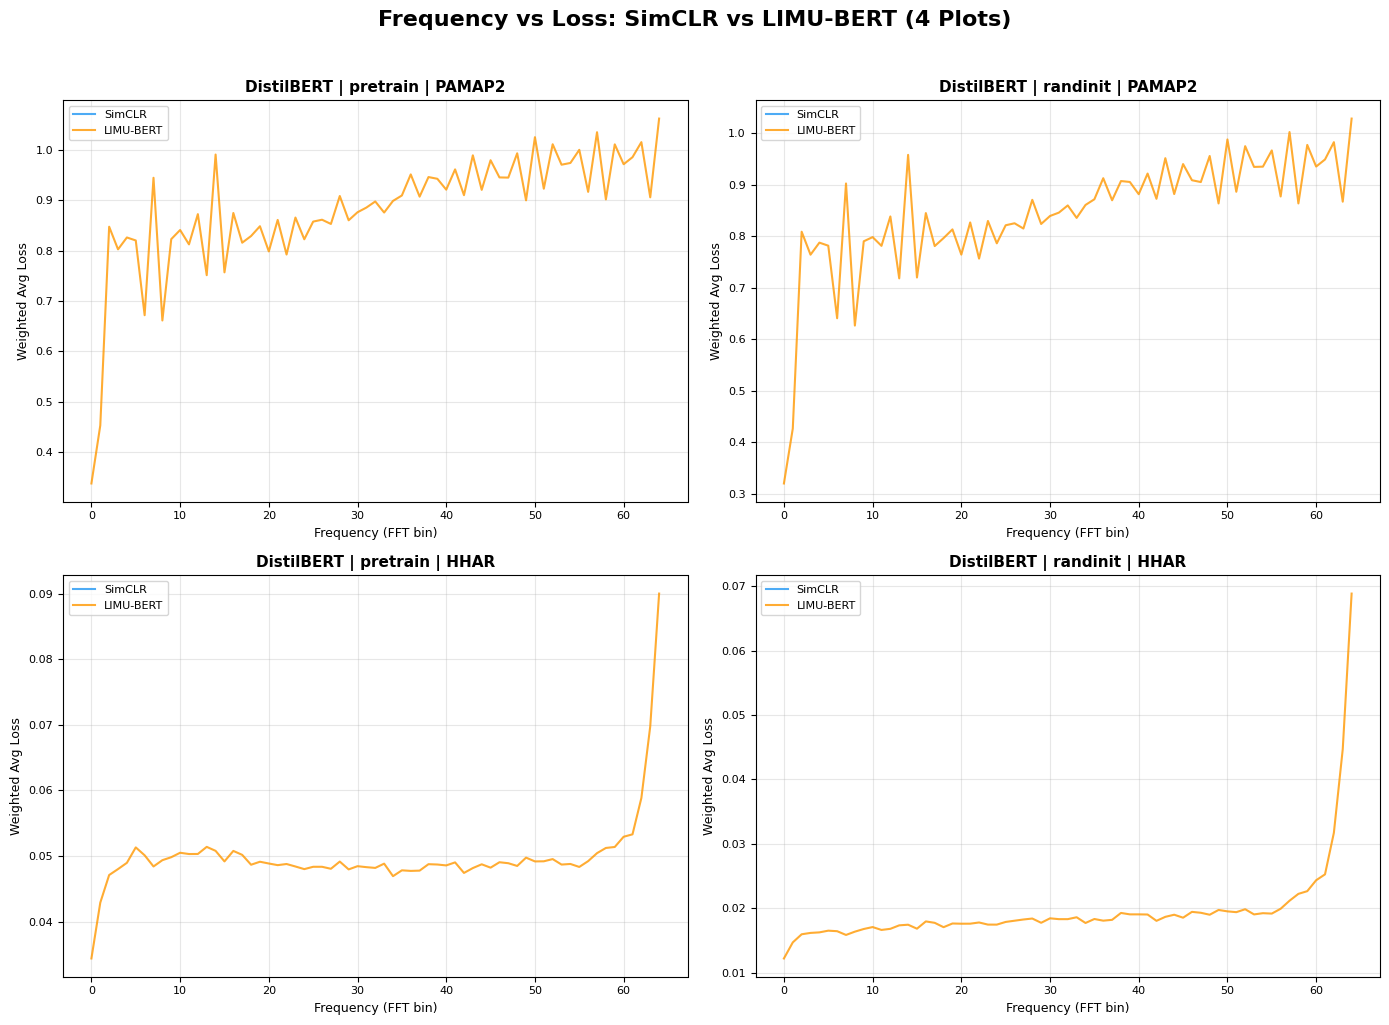

Saved: frequency_loss_4plots.png


In [4]:
# ── 4개 Plot: (model, init, dataset) 별로 SimCLR vs LIMU-BERT ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Frequency vs Loss: SimCLR vs LIMU-BERT (4 Plots)', fontsize=16, fontweight='bold', y=1.02)

plot_idx = 0
for dataset_name in DATASETS:
    freqs = results[dataset_name]['freqs']
    
    for init_mode in INIT_MODES:
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axes[row, col]
        
        for model_id in MODEL_IDS:
            model_data = results[dataset_name]['models'][model_id][init_mode]
            
            simclr_fl = model_data.get('simclr')
            limu_fl = model_data.get('limu_bert')
            
            if simclr_fl is not None:
                ax.plot(freqs, simclr_fl, label='SimCLR', color='#2196F3', linewidth=1.5, alpha=0.8)
            if limu_fl is not None:
                ax.plot(freqs, limu_fl, label='LIMU-BERT', color='#FF9800', linewidth=1.5, alpha=0.8)
        
        short_name = MODEL_SHORT_NAMES[MODEL_IDS[0]]
        ax.set_title(f'{short_name} | {init_mode} | {dataset_name.upper()}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Frequency (FFT bin)', fontsize=9)
        ax.set_ylabel('Weighted Avg Loss', fontsize=9)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)
        
        plot_idx += 1

plt.tight_layout()
plt.savefig('frequency_loss_4plots.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: frequency_loss_4plots.png')

## 4. 2개 Plot: 같은 모델 × 같은 데이터셋에서 pretrain vs randinit + SimCLR vs LIMU-BERT 비교

각 plot: 1개 모델 × 1개 데이터셋, 4개 라인 (SimCLR-pretrain, SimCLR-randinit, LIMU-pretrain, LIMU-randinit)

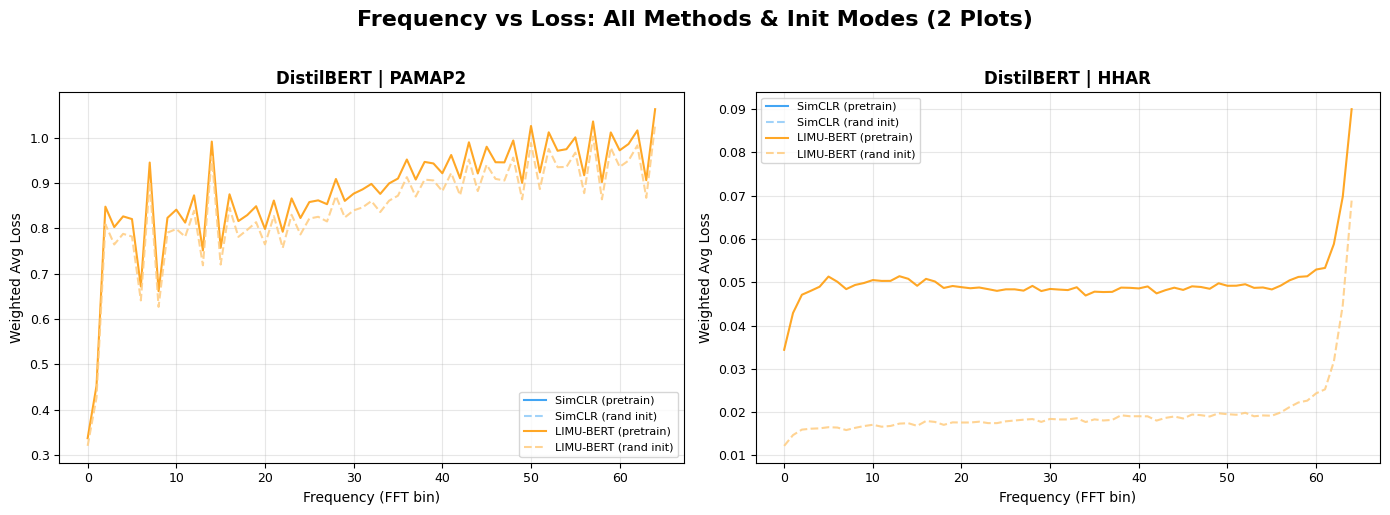

Saved: frequency_loss_2plots.png


In [5]:
# ── 2개 Plot: (model, dataset) 별로 4개 라인 ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Frequency vs Loss: All Methods & Init Modes (2 Plots)', fontsize=16, fontweight='bold', y=1.02)

COLORS = {
    ('simclr', 'pretrain'): '#2196F3',       # Blue
    ('simclr', 'randinit'): '#90CAF9',       # Light Blue
    ('limu_bert', 'pretrain'): '#FF9800',    # Orange
    ('limu_bert', 'randinit'): '#FFCC80',    # Light Orange
}
LABELS = {
    ('simclr', 'pretrain'): 'SimCLR (pretrain)',
    ('simclr', 'randinit'): 'SimCLR (rand init)',
    ('limu_bert', 'pretrain'): 'LIMU-BERT (pretrain)',
    ('limu_bert', 'randinit'): 'LIMU-BERT (rand init)',
}
LINESTYLES = {
    ('simclr', 'pretrain'): '-',
    ('simclr', 'randinit'): '--',
    ('limu_bert', 'pretrain'): '-',
    ('limu_bert', 'randinit'): '--',
}

for di, dataset_name in enumerate(DATASETS):
    freqs = results[dataset_name]['freqs']
    ax = axes[di]
    
    for model_id in MODEL_IDS:
        for method in METHODS:
            for init_mode in INIT_MODES:
                freq_loss = results[dataset_name]['models'][model_id][init_mode].get(method)
                if freq_loss is not None:
                    key = (method, init_mode)
                    ax.plot(freqs, freq_loss,
                            label=LABELS[key],
                            color=COLORS[key],
                            linestyle=LINESTYLES[key],
                            linewidth=1.5, alpha=0.85)
    
    short_name = MODEL_SHORT_NAMES[MODEL_IDS[0]]
    ax.set_title(f'{short_name} | {dataset_name.upper()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Frequency (FFT bin)', fontsize=10)
    ax.set_ylabel('Weighted Avg Loss', fontsize=10)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig('frequency_loss_2plots.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: frequency_loss_2plots.png')

In [6]:
# ── 전체 결과 요약 테이블 ──
print("=" * 100)
print("SUMMARY TABLE: Mean Frequency-weighted Loss")
print("=" * 100)
print(f"{'Dataset':<8} {'Model':<14} {'Init':<10} {'Method':<12} {'Mean Freq Loss':<16}")
print("-" * 100)

for dataset_name in DATASETS:
    for model_id in MODEL_IDS:
        short_name = MODEL_SHORT_NAMES[model_id]
        for init_mode in INIT_MODES:
            for method in METHODS:
                fl = results[dataset_name]['models'][model_id][init_mode].get(method)
                if fl is not None:
                    mean_fl = fl.mean()
                    print(f"{dataset_name.upper():<8} {short_name:<14} {init_mode:<10} {method:<12} {mean_fl:<16.4f}")
                else:
                    print(f"{dataset_name.upper():<8} {short_name:<14} {init_mode:<10} {method:<12} {'N/A':<16}")
    print("-" * 100)

SUMMARY TABLE: Mean Frequency-weighted Loss
Dataset  Model          Init       Method       Mean Freq Loss  
----------------------------------------------------------------------------------------------------
PAMAP2   DistilBERT     pretrain   simclr       -inf            
PAMAP2   DistilBERT     pretrain   limu_bert    0.8822          
PAMAP2   DistilBERT     randinit   simclr       -inf            
PAMAP2   DistilBERT     randinit   limu_bert    0.8460          
----------------------------------------------------------------------------------------------------
HHAR     DistilBERT     pretrain   simclr       -inf            
HHAR     DistilBERT     pretrain   limu_bert    0.0499          
HHAR     DistilBERT     randinit   simclr       -inf            
HHAR     DistilBERT     randinit   limu_bert    0.0197          
----------------------------------------------------------------------------------------------------
